# Detecting Bad Buzz with Deep Learning

## Developing an AI Solution to Predict Social Media Sentiment 

<div style="text-align: center;">
    <img src="../imgs/10.24_dlab_newsletter_image.png" alt="Image Alt Text" style="width: 50%;">
</div>

### Introduction

Welcome to the project titled "Detecting Bad Buzz with Deep Learning." In this project, you will step into the role of an AI engineer at MIC (Marketing Intelligence Consulting), a company specializing in digital marketing solutions. Your mission is to create an AI product that can predict sentiments associated with tweets. You've been commissioned by "Air Paradis," an airline company looking to improve its social media reputation.

This document will guide you through the various stages of the project, from data collection to model deployment. You will explore different approaches to sentiment analysis, including both simple and advanced deep learning models. Additionally, you'll gain hands-on experience in implementing MLOps (Machine Learning Operations) principles for model management and deployment.

Let's dive into the project overview to understand the context and objectives.

### Project Overview

Air Paradis has tasked your consultancy with developing a functional prototype of an AI product capable of predicting the sentiment of tweets. Given the airline's sometimes unfavorable reputation on social media, they are keen to anticipate and mitigate potential negative buzz.

The key project objectives include:

- Collecting and preparing a suitable dataset for model training.
- Developing two sentiment analysis models: a "Custom Simple Model" for quick results and a "Custom Advanced Model" based on deep learning for superior accuracy.
- Implementing and demonstrating the MLOps approach, focusing on MLFlow for model tracking and management.
- Deploying the best-performing advanced model as an API on a cloud service.
- Creating a blog post to share insights and comparisons of the different approaches and the MLOps strategy.
- Preparing a presentation slide deck to showcase the methodological approach, model results, and deployment process.

Throughout the project, you'll explore various aspects of machine learning, including data preprocessing, model evaluation, and deployment best practices. By the end, you'll have a comprehensive understanding of how to approach real-world AI projects and deliver valuable solutions to clients.


<!-- Sentiment140 Dataset Summary -->

### Dataset presentation

The Sentiment140 dataset is a collection of 1.6 million tweets that have been annotated with sentiment labels. It is a valuable resource for sentiment analysis tasks, particularly in the context of Twitter data.

#### Dataset Information

* Number of tweets: 1,600,000
* Sentiment classes: positive, neutral, negative
* Sources: news organizations, celebrities, everyday people
* Date range: 2009
* Download link: https://nlp.stanford.edu/sentiment/

#### Limitations

* The tweets are from 2009, so they may not be representative of current sentiment.
* The tweets are not evenly distributed across the three sentiment classes. There are more positive tweets than negative tweets.
* The tweets are not labeled by human annotators, so there may be some errors in the labels.

#### Key Fields

* **target:** Represents the sentiment polarity of each tweet, with values 0 (negative), 2 (neutral), and 4 (positive).
* **ids:** Contains unique identifiers for each tweet.
* **date:** Records the timestamp when each tweet was posted in a specific format.
* **flag:** Indicates the query used to obtain the tweet; set to "NO_QUERY" for tweets without a query.
* **user:** Provides the Twitter username of the user who posted the tweet.
* **text:** Contains the text content of each tweet.

<!-- End of Sentiment140 Dataset Summary -->


### Import libraries

In [53]:
import re
import string
import time

import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import FreqDist

import spacy

from unidecode import unidecode

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import joblib
import mlflow

zip_file = "../data/archive.zip"
output_dir = "../data/sentiment140"

# DATASET
# Define column names as a list
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

### Data collection

##### Unzipping dataset File

In [54]:
def unzip_file(zip_file, output_dir):
    with zipfile.ZipFile(zip_file) as zip_ref:
        zip_ref.extractall(output_dir)

unzip_file(zip_file, output_dir)

##### Get a List of CSV Files in data Directory

In [55]:
# Use glob to get a list of CSV files in the directory
csv_files = glob.glob(f'{output_dir}/*.csv')

# Now, csv_files contains a list of paths to all CSV files in the directory
for csv_file in csv_files:
    print(csv_file)

../data/sentiment140/debug16000.csv
../data/sentiment140/debug1600.csv
../data/sentiment140/training.1600000.processed.noemoticon.csv
../data/sentiment140/debug.csv
../data/sentiment140/debug160000.csv


##### Reading and Previewing CSV Data

In [56]:
# Read the CSV file into a DataFrame with the specified encoding and column names
df = pd.read_csv(csv_files[2], encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Display the first few rows of the DataFrame to check the data
df.head(3)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [19]:
def create_debug_dataset(df):
  """Creates a debug dataset that contains 160,000 rows, with 80,000 rows equal to 1 and 80,000 rows equal to 0."""
  # df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

  n_rows = len(df)
  n_rows_per_class = int(n_rows / 100 / 2)

  df_debug_0 = df[df['target'] == 0].sample(n_rows_per_class)
  df_debug_4 = df[df['target'] == 4].sample(n_rows_per_class)

  df_debug = pd.concat([df_debug_0, df_debug_4])
  df_debug = df_debug.sample(frac=1).reset_index(drop=True)

  df_debug.to_csv('../data/sentiment140/debug16000.csv', index=False)
  return df_debug
df = create_debug_dataset(df)


##### Get the Shape of a Pandas DataFrame

In [57]:
print(f"DataFrame Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

DataFrame Shape: (1600000, 6)
Number of Rows: 1600000
Number of Columns: 6


##### DataFrame Information

In [58]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


##### Changing values in the "target" column and visualizing its distribution.

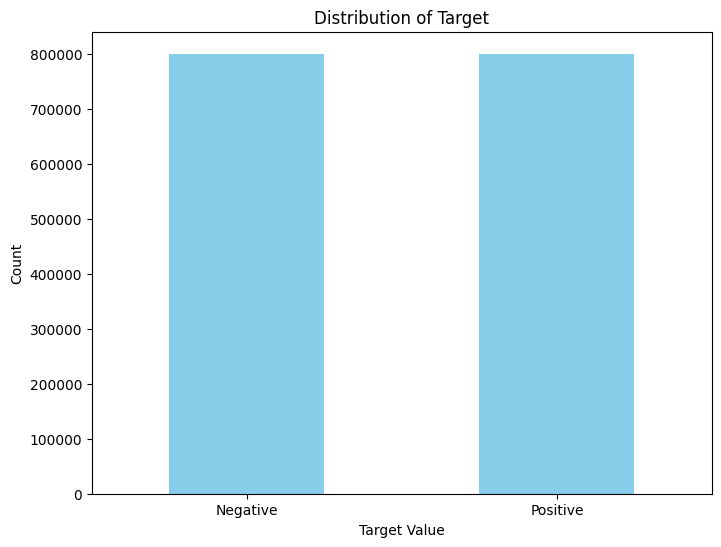

In [59]:
# Replace 4 with 1 in the "target" column
df["target"] = df["target"].replace(4, 1)

# Plot the distribution of the "target" column
plt.figure(figsize=(8, 6))
df["target"].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Target')
plt.xlabel('Target Value')
plt.ylabel('Count')
# plt.xticks(rotation=0)

# Set the bar names to "positive" and "negative"
plt.xticks([0, 1], ["Negative", "Positive"], rotation=0)
plt.show()

**Observation:**
- We can shows that the Sentiment140 dataset is **balanced**, with **800,000 tweets** in each of the positive and negative sentiment classes. This is important because it means that the model will not be biased towards predicting one class over the other.

##### Exploring and Removing the 'flag' Column

In [60]:
# Display the number of times each unique value appears in the "country" column
display(df["flag"].value_counts())

# Efficiently remove the 'flag' column in-place from the DataFrame.
df.drop("flag", axis=1, inplace=True)

flag
NO_QUERY    1600000
Name: count, dtype: int64

**Observation:**
- The "**flag**" column contains a single unique value "**NO_QUERY**", which suggests that it does not provide any meaningful information and can be safely removed from the dataframe.

##### Add a New Row to a DataFrame with Emojis

In [61]:
# Define the new row as a dictionary with the same keys as the DataFrame columns
new_row = {
    "target": 1,
    "ids": 1234567890,
    "date": "Sun Sep 18 12:34:56 PDT 2023",
    "flag": "NO_QUERY",
    "user": "new_user",
    "text": "This is a new row with emojis: 😃 😄"
}

# Use the loc property to add the new row to the DataFrame
df.loc[len(df)] = new_row

# Display the DataFrame with the new row
df.tail(1)


,target,ids,date,user,text
1600000,1,1234567890,Sun Sep 18 12:34:56 PDT 2023,new_user,This is a new row with emojis: 😃 😄


##### Find and Extract Emojis from Text

In [62]:
# Define a regular expression pattern to match a wide range of emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U0001F004-\U0001F0CF"  # CJK Ideographs & Punctuation
                           u"\U0001F170-\U0001F251"  # Enclosed Ideographic Supplement
                           "]+", flags=re.UNICODE)

# Function to find emojis in a text and return them as a list
def find_emojis(text):
    emojis = emoji_pattern.findall(text)
    return emojis

# Apply the find_emojis function to the 'text' column and create a new 'emojis' column
df['emojis'] = df['text'].apply(find_emojis)
df['text'] = df['text'].apply(lambda x: emoji_pattern.sub(r'', x))

# Filter rows where the 'emojis' column is not empty
non_empty_emojis_df = df[df['emojis'].apply(len) > 0]

# Display the filtered DataFrame
non_empty_emojis_df


,target,ids,date,user,text,emojis
1600000,1,1234567890,Sun Sep 18 12:34:56 PDT 2023,new_user,This is a new row with emojis:,"[😃, 😄]"


In [63]:
# Define a list of new rows to be appended to the DataFrame
new_rows = [
    [0, 1467811169, "Mon Apr 06 22:20:01 PDT 2009", "new_user1", "On a beautiful sunny day, @new_user1 exclaimed, Spending time with @Bard and @Cupcake is always a delight!", ""],
    [0, 1467811417, "Mon Apr 06 22:20:05 PDT 2009", "new_user2", "On a cheerful morning, @new_user2 shared, Having a blast with @Bard and @Cupcake today!", ""],
    [0, 1467811669, "Mon Apr 06 22:20:09 PDT 2009", "new_user3", "On a lovely afternoon, @new_user3@ replied to @Cupcake, saying, Your positivity brightens my day!", ""]
]

for new_row in new_rows:
    # Concatenate the new rows to the DataFrame
    df.loc[len(df)] = new_row
df.tail(4)

,target,ids,date,user,text,emojis
1600000,1,1234567890,Sun Sep 18 12:34:56 PDT 2023,new_user,This is a new row with emojis:,"[😃, 😄]"
1600001,0,1467811169,Mon Apr 06 22:20:01 PDT 2009,new_user1,"On a beautiful sunny day, @new_user1 exclaimed...",
1600002,0,1467811417,Mon Apr 06 22:20:05 PDT 2009,new_user2,"On a cheerful morning, @new_user2 shared, Havi...",
1600003,0,1467811669,Mon Apr 06 22:20:09 PDT 2009,new_user3,"On a lovely afternoon, @new_user3@ replied to ...",


In [64]:
import re

def find_usernames(tweet):
    # Define a regex pattern for finding usernames
    pattern = r'@([A-Za-z0-9_]+)'
    
    # Use re.findall to find all matching usernames in the text
    usernames = re.findall(pattern, tweet)
    return usernames

# Apply the find_emojis function to the 'text' column and create a new 'emojis' column
df['username'] = df['text'].apply(find_usernames)
df['text'] = df['text'].apply(lambda x: re.sub(r'\@[A-Za-z0-9_]+', '', x))

# Filter rows where the 'emojis' column is not empty
non_empty_username_df = df[df['username'].apply(len) > 0]

# Display the filtered DataFrame
non_empty_username_df.tail()


,target,ids,date,user,text,emojis,username
1599994,1,2193579489,Tue Jun 16 08:39:00 PDT 2009,EvolveTom,"Yeah, that does work better than just waiting...",[],[Cliff_Forster]
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,RyanTrevMorris,happy #charitytuesday,[],"[theNSPCC, SparksCharity, SpeakingUpH4H]"
1600001,0,1467811169,Mon Apr 06 22:20:01 PDT 2009,new_user1,"On a beautiful sunny day, exclaimed, Spending...",,"[new_user1, Bard, Cupcake]"
1600002,0,1467811417,Mon Apr 06 22:20:05 PDT 2009,new_user2,"On a cheerful morning, shared, Having a blast...",,"[new_user2, Bard, Cupcake]"
1600003,0,1467811669,Mon Apr 06 22:20:09 PDT 2009,new_user3,"On a lovely afternoon, @ replied to , saying, ...",,"[new_user3, Cupcake]"


In [65]:
# Create a DataFrame for the new tweets with URLs inside text
new_tweets_data = [
    [0, 1, "Tue Sep 07 14:00:00 PDT 2023", "user1", "Just discovered an interesting article on data science: https://www.example.com/data-science-article", [], ["data_lover"]],
    [0, 2, "Tue Sep 07 14:15:00 PDT 2023", "user2", "Exciting news! Our website is live now. Check it out: https://www.example.com", [], ["website_news"]],
    [0, 3, "Tue Sep 07 14:30:00 PDT 2023", "user3", "Spent the day exploring new recipes. Here's my favorite: https://www.example.com/recipe", [], ["foodie"]],
    [0, 4, "Tue Sep 07 14:45:00 PDT 2023", "user4", "Reading a captivating book. Highly recommend it: https://www.example.com/book", [], ["bookworm"]],
    [0, 5, "Tue Sep 07 15:00:00 PDT 2023", "user5", "Watched an incredible documentary last night: https://www.example.com/documentary", [], ["movie_buff"]],
]


# Create a DataFrame for the new tweets with URLs inside text
# new_tweets_df = pd.DataFrame(new_tweets_data)

for new_row in new_tweets_data:
    # Concatenate the new rows to the DataFrame
    df.loc[len(df)] = new_row
df.tail(5)

,target,ids,date,user,text,emojis,username
1600004,0,1,Tue Sep 07 14:00:00 PDT 2023,user1,Just discovered an interesting article on data...,[],[data_lover]
1600005,0,2,Tue Sep 07 14:15:00 PDT 2023,user2,Exciting news! Our website is live now. Check ...,[],[website_news]
1600006,0,3,Tue Sep 07 14:30:00 PDT 2023,user3,Spent the day exploring new recipes. Here's my...,[],[foodie]
1600007,0,4,Tue Sep 07 14:45:00 PDT 2023,user4,Reading a captivating book. Highly recommend i...,[],[bookworm]
1600008,0,5,Tue Sep 07 15:00:00 PDT 2023,user5,Watched an incredible documentary last night: ...,[],[movie_buff]


In [66]:
def find_urls(tweet):
    # Define a regex pattern for finding urls
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    # Use re.findall to find all matching urls in the text
    urls = re.findall(url_pattern, tweet)
    return urls

# Define a function to remove or replace URLs in the text
def remove_or_replace_urls(text, replace_with=""):
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    return re.sub(url_pattern, replace_with, text)

# Apply the function to remove or replace URLs in the 'tweets' column
df['url'] = df['text'].apply(find_urls)
df['text'] = df['text'].apply(remove_or_replace_urls)

# Display the DataFrame with URLs removed or replaced
df.tail(5)


,target,ids,date,user,text,emojis,username,url
1600004,0,1,Tue Sep 07 14:00:00 PDT 2023,user1,Just discovered an interesting article on data...,[],[data_lover],[https://www.example.com/data-science-article]
1600005,0,2,Tue Sep 07 14:15:00 PDT 2023,user2,Exciting news! Our website is live now. Check ...,[],[website_news],[https://www.example.com]
1600006,0,3,Tue Sep 07 14:30:00 PDT 2023,user3,Spent the day exploring new recipes. Here's my...,[],[foodie],[https://www.example.com/recipe]
1600007,0,4,Tue Sep 07 14:45:00 PDT 2023,user4,Reading a captivating book. Highly recommend it:,[],[bookworm],[https://www.example.com/book]
1600008,0,5,Tue Sep 07 15:00:00 PDT 2023,user5,Watched an incredible documentary last night:,[],[movie_buff],[https://www.example.com/documentary]


In [67]:
# Add a new column 'text_length' to the DataFrame with the length of the 'text' column
df['tweet_length'] = df['text'].apply(len)
df.head(3)

,target,ids,date,user,text,emojis,username,url,tweet_length
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- Awww, that's a bummer. You shoulda got Da...",[],[switchfoot],[http://twitpic.com/2y1zl],80
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,[],[],[],111
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball. Managed to s...,[],[Kenichan],[],80


In [68]:
tweet_df = df[['text', 'target', 'tweet_length']]
tweet_df.head()

,text,target,tweet_length
0,"- Awww, that's a bummer. You shoulda got Da...",0,80
1,is upset that he can't update his Facebook by ...,0,111
2,I dived many times for the ball. Managed to s...,0,80
3,my whole body feels itchy and like its on fire,0,47
4,"no, it's not behaving at all. i'm mad. why am...",0,95


### Analyzing the Mean Length of Tweets
#### Calculating the average length of tweets in the 'tweet_length' column

In [69]:
print('Mean length: ', tweet_df['tweet_length'].mean())


Mean length:  67.5278495308464


/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


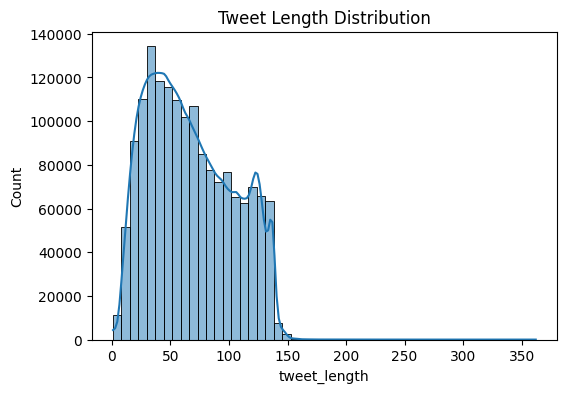

In [70]:
# Create the histogram
fig = plt.figure(figsize=(6, 4))
sns.histplot(tweet_df['tweet_length'], kde=True, bins=50)
plt.title('Tweet Length Distribution')
plt.show()

# Normalizing text 🧹

The quality of our data is crucial for building a high-quality model. In order to ensure data quality and improve the effectiveness of our models, we employ preprocessing techniques using the Gensim and SpaCy libraries.

## Preprocessing Steps:

1. **Lowercasing:** 
2. **Expand Contractions:** 
3. **Tokenizing:** 
4. **Removal of Special Characters:** 
5. **Removal of Punctuations:** 
6. **Removal of Stopwords:** 
7. **Removal of Tokens with Only 1 Character:** 
8. **Lemmatization:** 


#### Lowercasing 🔡

Converting text to lower case in NLP ensures compatibility with tools, libraries, and models designed for lower case text, avoiding issues and ensuring smooth processing.

In [71]:
tweet_df = df.copy()

In [72]:
tweet_df.loc[:, 'text'] = tweet_df['text'].str.lower()
tweet_df.text.head()

0      - awww, that's a bummer.  you shoulda got da...
1    is upset that he can't update his facebook by ...
2     i dived many times for the ball. managed to s...
3      my whole body feels itchy and like its on fire 
4     no, it's not behaving at all. i'm mad. why am...
Name: text, dtype: object

#### Expand contractions

In [73]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [74]:
tweet_df['clean_tweet'] = tweet_df['text'].apply(expand_contractions)
# tweet_df['clean_tweet_length'] = tweet_df['clean_tweet'].str.len()

display(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))


'  - awww, that is a bummer.  you shoulda got david carr of third day to do it. ;d'

,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"- awww, that is a bummer. you shoulda got d..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,is upset that he cannot update his facebook by...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,i dived many times for the ball. managed to s...


In [75]:
tweet_df.loc[:, 'clean_tweet'] = tweet_df['text'].apply(lambda x: word_tokenize(x))

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['-', 'awww', ',', 'that', "'s", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[-, awww, ,, that, 's, a, bummer, ., you, shou..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[is, upset, that, he, ca, n't, update, his, fa..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[i, dived, many, times, for, the, ball, ., man..."


In [76]:
corpus = tweet_df['clean_tweet'].str.join(" ")

# Assuming 'reviews' is the column containing the text with accented characters
accented_words = corpus.str.findall(r'\b\w*[^\x00-\x7F]+\w*\b')

# Flatten the list of accented words
accented_words = [word for sublist in accented_words for word in sublist]

# Remove duplicates and sort the accented words
accented_words = sorted(set(accented_words))

# Print the accented words
print("Exemple of Accented and Unicode Characters in the corpus:")
display(accented_words[:5])

Exemple of Accented and Unicode Characters in the corpus:


['003ï¿½', '04å¹´ç\x9a\x84èµ¤è', '08ï¿½', '0ã', '0ì']

In [77]:
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda tokens: [unidecode(token) for token in tokens])

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['-', 'awww', ',', 'that', "'s", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[-, awww, ,, that, 's, a, bummer, ., you, shou..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[is, upset, that, he, ca, n't, update, his, fa..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[i, dived, many, times, for, the, ball, ., man..."


In [78]:
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['awww', 'that', "'s", 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[awww, that, 's, a, bummer, you, shoulda, got,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[is, upset, that, he, ca, n't, update, his, fa..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[i, dived, many, times, for, the, ball, manage..."


In [79]:
def remove_non_alphabetic_characters(token):
    token = re.sub(r'[^a-zA-Z]', '', token)
    return token
    
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda tokens: [remove_non_alphabetic_characters(token) for token in tokens])

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['awww', 'that', 's', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[awww, that, s, a, bummer, you, shoulda, got, ..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[is, upset, that, he, ca, nt, update, his, fac..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[i, dived, many, times, for, the, ball, manage..."


In [80]:
# Remove stopwords
stop_words = set(stopwords.words("english"))
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[awww, bummer, shoulda, got, david, carr, thir..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[upset, ca, nt, update, facebook, texting, , m..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[dived, many, times, ball, managed, save, , re..."


In [81]:
# Create a function to remove tokens with only 1 character
def remove_single_character_tokens(tokens):
    return [token for token in tokens if len(token) > 1]
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(remove_single_character_tokens)

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[awww, bummer, shoulda, got, david, carr, thir..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[upset, ca, nt, update, facebook, texting, mig..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[dived, many, times, ball, managed, save, rest..."


In [82]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download the WordNet dataset if you haven't already
nltk.download('wordnet')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define lemmatization function
def lemmatize_text(tokens):
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return lemmatized_text

# Function to get WordNet POS tags for NLTK lemmatizer
def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Start measuring elapsed time
start_time = time.time()

# Apply lemmatization to 'clean_tweet' column
tweet_df['clean_tweet'] = [lemmatize_text(tokens) for tokens in tweet_df['clean_tweet']]

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# Display the lemmatized text
print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))


[nltk_data] Downloading package wordnet to /Users/drainasr-
[nltk_data]     edine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Elapsed time: 1659.0610358715057 seconds
['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'third', 'day']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"- awww, that's a bummer. you shoulda got da...",[],[switchfoot],[http://twitpic.com/2y1zl],80,"[awww, bummer, shoulda, get, david, carr, thir..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his facebook by ...,[],[],[],111,"[upset, ca, nt, update, facebook, texting, mig..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball. managed to s...,[],[Kenichan],[],80,"[dive, many, time, ball, manage, save, rest, g..."


In [46]:
!python -m spacy download en_core_web_sm

2023-10-04 11:57:03.968019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
     |████████████████████████████████| 12.8 MB 29.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [47]:

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# Define lemmatization function
def lemmatize_text(tokens):
    doc = nlp(' '.join(tokens))
    lemmatized_text = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADV']]
    return lemmatized_text

# Start measuring elapsed time
start_time = time.time()

# Apply lemmatization to 'clean_tweet' column
tweet_df['clean_tweet'] = [lemmatize_text(tokens) for tokens in tweet_df['clean_tweet']]

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
# tweet_df['clean_tweet_length'] = tweet_df['clean_tweet'].apply(lambda tokens: sum(len(token) for token in tokens))

print(tweet_df.loc[:, 'clean_tweet'][0]) 
display(tweet_df.head(3))

Elapsed time: 102.27525806427002 seconds
['girlfriend', 'harrasse', 'people', 'class']


,target,ids,date,user,text,emojis,username,url,tweet_length,clean_tweet
0,1,1957099063,Thu May 28 23:30:53 PDT 2009,Dopplertom,my imaginary girlfriend and we harrassing peo...,[],[addyx21],[],68,"[girlfriend, harrasse, people, class]"
1,0,2063777023,Sun Jun 07 04:01:58 PDT 2009,anapostrero,"hey stephen, i miss you and your undershirt a...",[],[],[],70,[shoe]
2,0,1996566132,Mon Jun 01 15:18:05 PDT 2009,ayaueda,ya no pude ver el zapping zone completo... ashsh,[],[],[],49,"[pude, ver, ashsh]"


In [83]:
tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(remove_single_character_tokens)

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


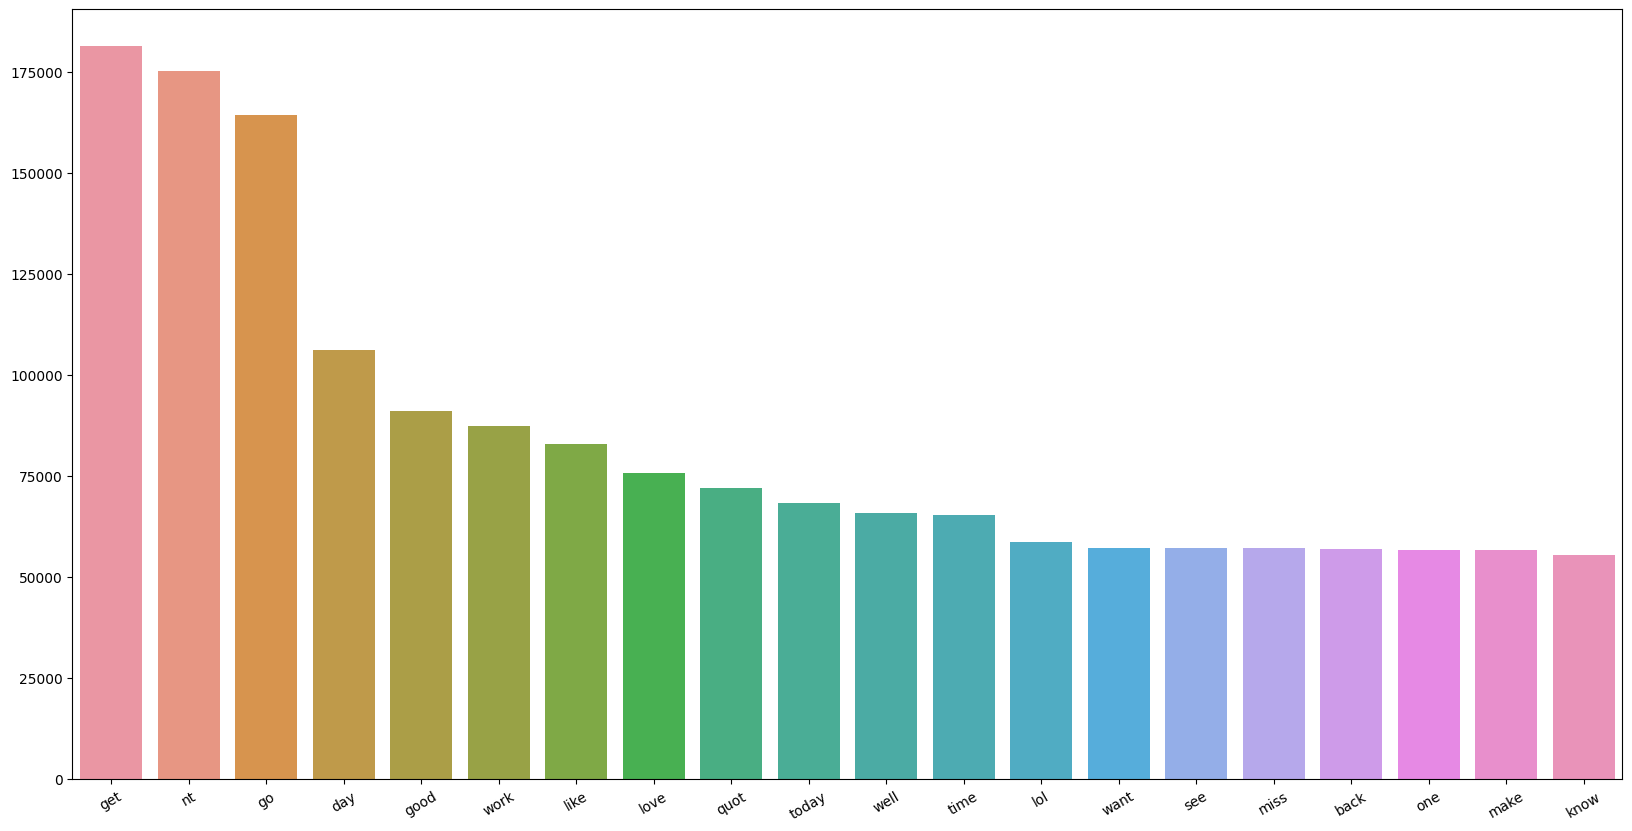

In [84]:
clean_tweet = tweet_df['clean_tweet'].copy()

# Combine all words into a single list
all_words = [word for review in clean_tweet for word in review]

# Creating FreqDist for the entire Bag of Words (BoW), keeping the 20 least common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Converting FreqDist to a Pandas Series for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting up the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Plotting using Seaborn and Pandas attributes, rotating x-axis ticks for better visibility
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30)

# Display the plot
plt.show()


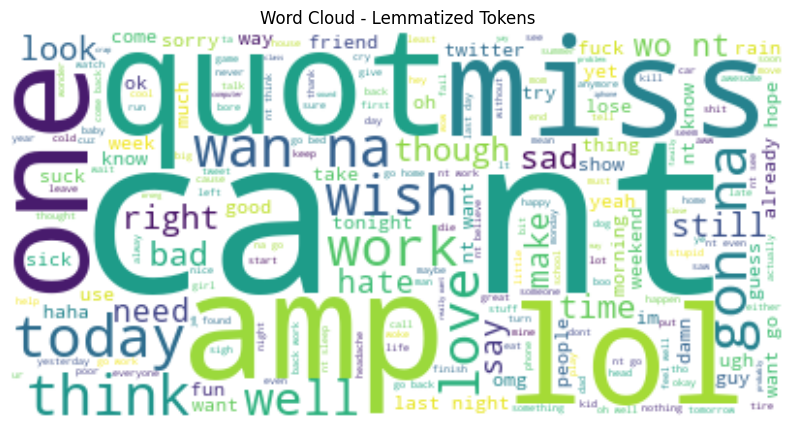

In [85]:
# Filter the DataFrame to keep only rows where 'target' is 0
filtered_df = tweet_df[tweet_df['target'] == 0]

# Create a new DataFrame containing the 'clean_tweet' column
clean_tweet = filtered_df['clean_tweet']

# Combine all words into a single list
all_words = [word for review in clean_tweet for word in review]

# Convert the list of tokens to a string
text = ' '.join(all_words)

# Generate the word cloud
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Lemmatized Tokens')
plt.show()


In [86]:
from collections import Counter

# Count the frequency of each word
word_counts = Counter(all_words)

# Sort the word-frequency pairs in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 most common words
top_20_words = sorted_word_counts[:20]

# Display the 20 most common words
for word, count in top_20_words:
    print(f"{word}: {count}")


nt: 121122
get: 100186
go: 96005
work: 58738
day: 51248
miss: 47793
like: 42716
want: 40219
today: 38190
feel: 36396
back: 33106
ca: 32137
really: 31472
time: 31247
im: 30560
well: 30223
still: 29249
good: 29090
one: 28694
know: 28024


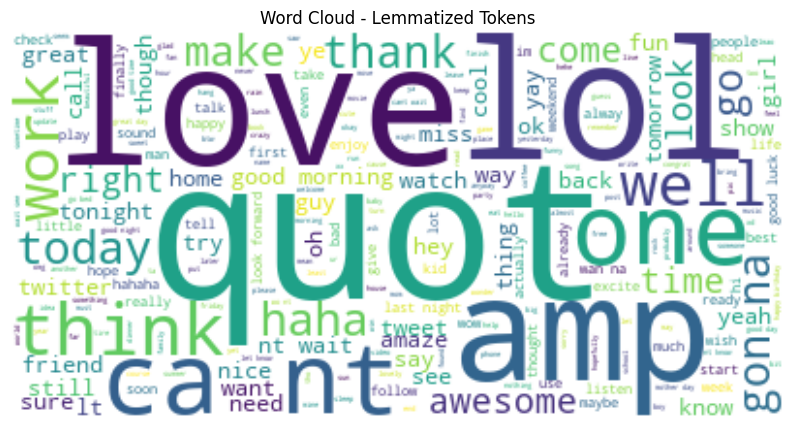

In [87]:
# Filter the DataFrame to keep only rows where 'target' is 0
filtered_df = tweet_df[tweet_df['target'] == 1]

# Create a new DataFrame containing the 'clean_tweet' column
clean_tweet = filtered_df['clean_tweet']

# Combine all words into a single list
all_words = [word for review in clean_tweet for word in review]

# Convert the list of tokens to a string
text = ' '.join(all_words)

# Generate the word cloud
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Lemmatized Tokens')
plt.show()
